# 🔬 SKINDX: Skin Cancer Detection - Data Analysis

**Deep Learning Pipeline for Medical Image Classification**

---

🎯 **Project Overview**

This notebook explores the **HAM10000 dataset** - a comprehensive collection of 10,015 dermatoscopic images spanning 7 different skin lesion types. We focus on understanding the data characteristics and challenges before building our classification model.

---

📊 **Dataset: HAM10000**

The Human Against Machine (HAM10000) dataset contains dermatoscopic images of common pigmented skin lesions, representing a realistic clinical case distribution.

**7 Skin Lesion Classes:**
1. **akiec** - Actinic keratoses and intraepithelial carcinoma
2. **bcc** - Basal cell carcinoma  
3. **bkl** - Benign keratosis-like lesions
4. **df** - Dermatofibroma
5. **mel** - Melanoma
6. **nv** - Melanocytic nevi (most common)
7. **vasc** - Vascular lesions

---

📋 **Project Pipeline**

This is the roadmap we'll follow across all notebooks in this project:

**1. Data Exploration** ← *This notebook*
- Class distribution analysis and visualization
- Image quality assessment and metadata exploration
- Visual pattern identification across lesion types

**2. Class Imbalance Handling**
- Advanced augmentation strategies for minority classes
- Smart sampling techniques to balance training data

**3. Model Training & Experiment Tracking**
- CNN baseline and ResNet-50 transfer learning
- **MLflow local tracking**: metrics, parameters, model artifacts
- Model comparison and best model selection

**4. External Validation**
- Real-world performance testing on **ISIC 2019 dataset**
- Comprehensive evaluation on 24,703 unseen images

---
- **Skill Level**: Intermediate Data Scientist
- **Environment**: NVIDIA PyTorch container with GPU acceleration  
- **Duration**: ~2-3 hours for complete pipeline

## 📚 Import Libraries 

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import random
from glob import glob
import pandas as pd
import os

input_path = "../data/HAM10000/"

## 📥 Load metadata

- Download manually from https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
- Keep only: HAM10000_metadata.csv, HAM10000_images_part_1/, HAM10000_images_part_2/
- Remove: hmnist_*.csv files (preprocessed versions not needed)

In [4]:
# Load metadata
metadata = pd.read_csv(os.path.join(input_path, "HAM10000_metadata.csv"))

# Get total number of samples in dataset
num_examples = metadata.values.shape[0]
print(f"✅ Dataset loaded: {num_examples} samples")

# Display dataframe
print("\n📊 First 5 rows:")
display(metadata.head())

✅ Dataset loaded: 10015 samples

📊 First 5 rows:


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
# Unique diagnosis classes
unique_dx = metadata["dx"].unique()
print("🔑 Unique dx values:", unique_dx)


🔑 Unique dx values: ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


## 🔍 Check missing values

In [6]:
print("\n🔍 Missing values:")
missing_percent = (metadata.isnull().sum() / len(metadata) * 100).round(2)
for col, percent in missing_percent.items():
    print(f"{col}: {percent}%")


🔍 Missing values:
lesion_id: 0.0%
image_id: 0.0%
dx: 0.0%
dx_type: 0.0%
age: 0.57%
sex: 0.0%
localization: 0.0%


0.57% missing values is negligible - less than 1% of the dataset. Leave them as-is; most ML models can handle such a small amount of missing data without issues.

## 🖼️ Show sample images

In [7]:
# Create image path mapping
image_path = {}
for part in ['HAM10000_images_part_1', 'HAM10000_images_part_2']:
    folder_path = os.path.join(input_path, part)
    part_images = {os.path.splitext(os.path.basename(x))[0]: x
                   for x in glob(os.path.join(folder_path, '*.jpg'))}
    image_path.update(part_images)

print(f"Found {len(image_path)} images")

Found 10015 images


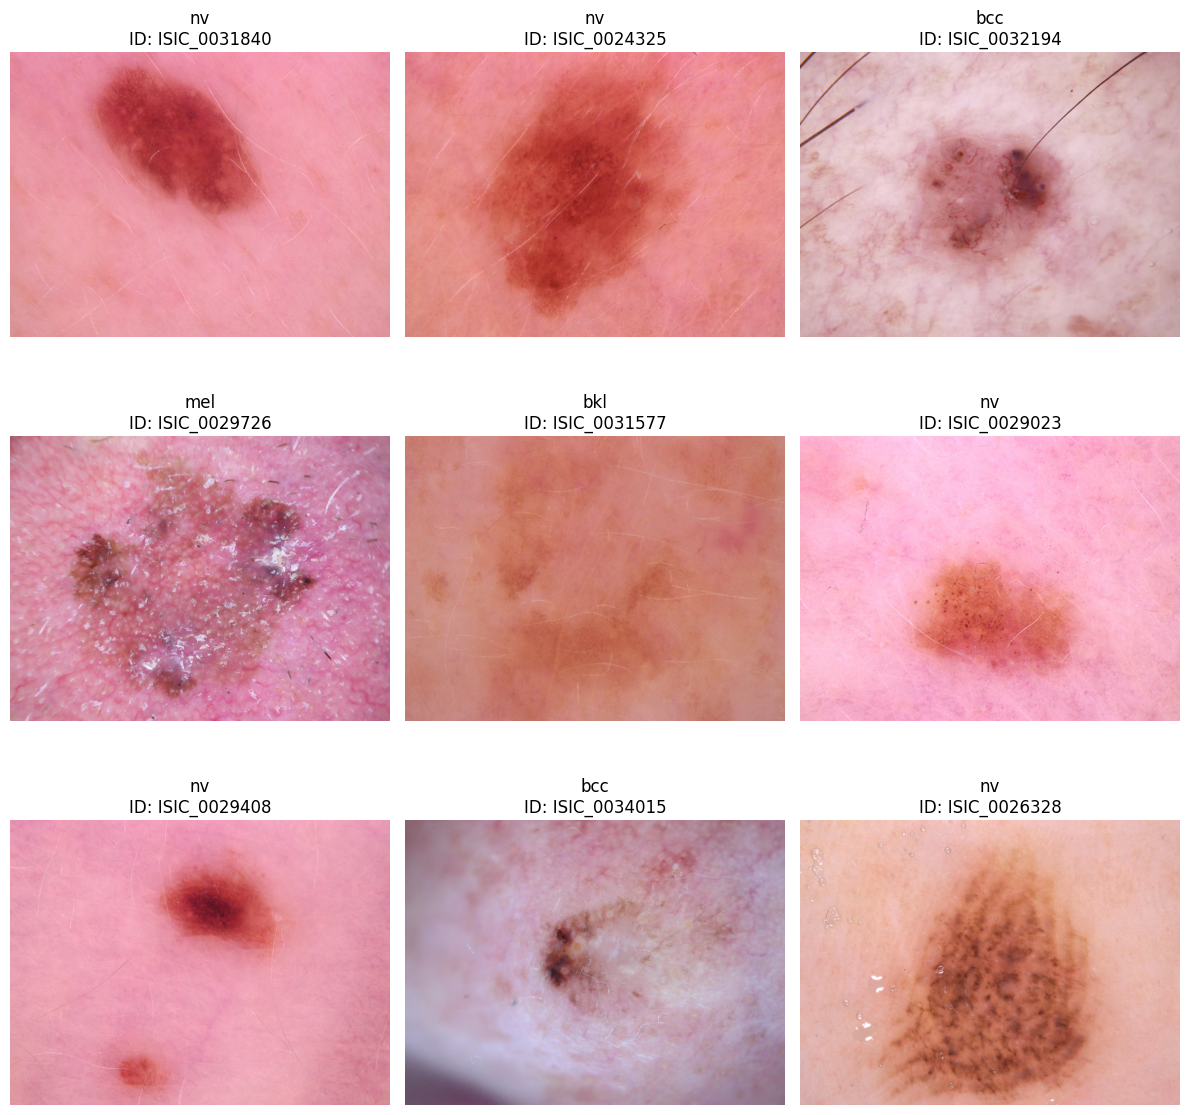

In [8]:
# Show sample images
random_ids = random.sample(list(image_path.keys()), 9)

plt.figure(figsize=(12, 12))
for i, img_id in enumerate(random_ids):
    img_path = image_path[img_id]
    img = Image.open(img_path)
    
    # Find the label for this image ID
    row = metadata[metadata['image_id'] == img_id]
    label = row['dx'].iloc[0] if not row.empty else 'Unknown'
    
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(f'{label}\nID: {img_id}')
    plt.axis('off')

plt.tight_layout()
plt.show()

## 👀 Check for missing images

In [9]:
missing_images = []
for img_id in metadata['image_id']:
   if img_id not in image_path:
       missing_images.append(img_id)

print(f"❌ Missing images: {len(missing_images)}")
if missing_images:
   print(f"First 5 missing: {missing_images[:5]}")

# Check all images have .jpg extension
non_jpg = [path for path in image_path.values() if not path.endswith('.jpg')]
print(f"❌ Non-JPG images: {len(non_jpg)}")

# Check for duplicate images in dataframe
duplicates = metadata['image_id'].duplicated().sum()
print(f"❌ Duplicate image IDs in metadata: {duplicates}")

print(f"\n✅ Total images found: {len(image_path)}")
print(f"✅ Total metadata entries: {len(metadata)}")

❌ Missing images: 0
❌ Non-JPG images: 0
❌ Duplicate image IDs in metadata: 0

✅ Total images found: 10015
✅ Total metadata entries: 10015


## 📊 Class distribution

Imbalanced dataset distribution:
dx
akiec     327
bcc       514
bkl      1099
df        115
mel      1113
nv       6705
vasc      142
Name: count, dtype: int64


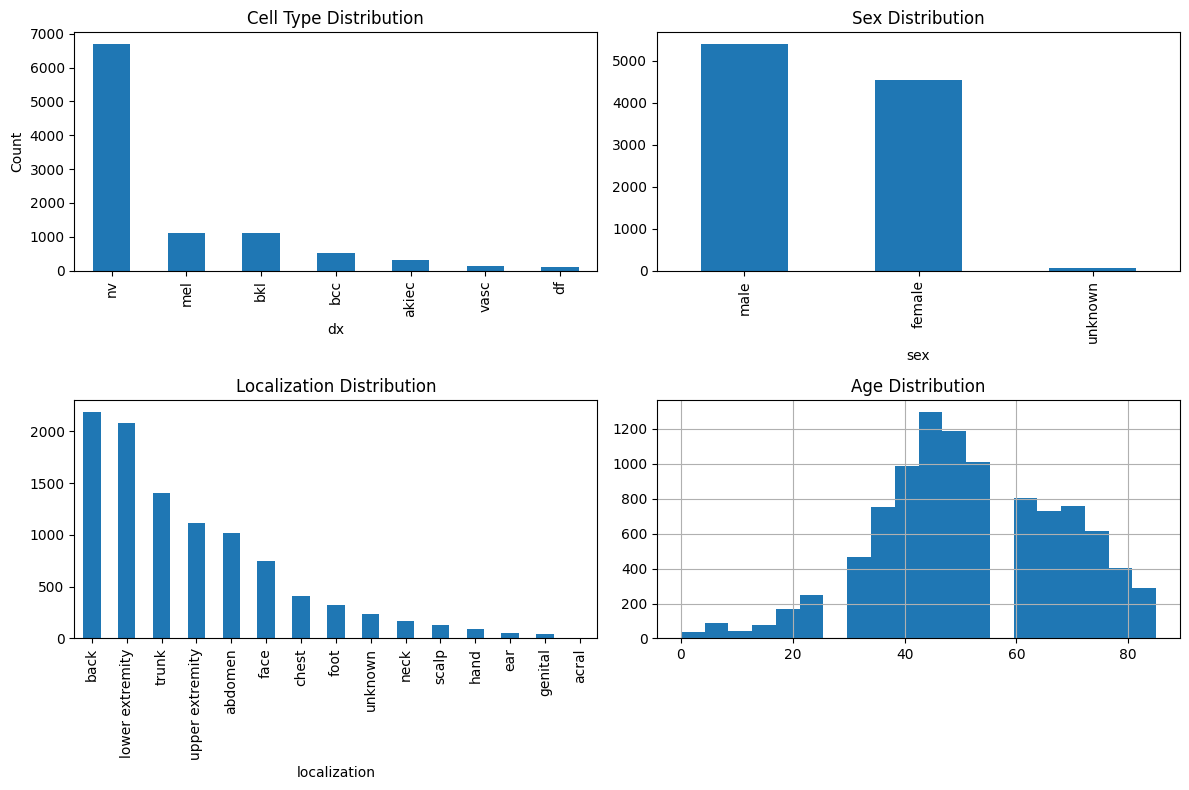

In [10]:
print("Imbalanced dataset distribution:")
print(metadata['dx'].value_counts().sort_index())

# Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

metadata['dx'].value_counts().plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Cell Type Distribution')
axes[0,0].set_ylabel('Count')

metadata['sex'].value_counts().plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Sex Distribution')

metadata['localization'].value_counts().plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Localization Distribution')

metadata['age'].hist(bins=20, ax=axes[1,1])
axes[1,1].set_title('Age Distribution')

plt.tight_layout()
plt.show()

The dataset shows extreme imbalance with nv having 6,705 samples while df has only 115 - we'll address this class imbalance with targeted augmentation strategies in the next notebook.